# Load torch device

In [1]:
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, AdamW

# --- this part is required for mac --- #
import sys, os
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '..', '..'))
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.insert(0, src_path)
if project_root not in sys.path:
    sys.path.insert(0, project_root)
# comment out if youre on windows and remove 'src.' prefixes from imports #

from src.Datasets.batching import BatchManager

# Apple Silicon (M1/M2/M3/M4) optimization
# IMPORTANT: torch-scatter and torch-spline-conv may not fully support MPS!
# Enable fallback to CPU for unsupported operations
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

# Multi-threading optimization for M4
# Set number of threads for PyTorch operations
torch.set_num_threads(4)  # M4 has 4 performance cores
print(f"PyTorch using {torch.get_num_threads()} threads for CPU operations")

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"Using device: {device} (Apple Silicon GPU acceleration)")
    print(f"MPS backend available: {torch.backends.mps.is_built()}")
    print(f"⚠️  NOTE: Some PyG operations will fall back to CPU (torch-scatter, torch-spline-conv)")
    print(f"   For best M4 performance, consider using conv_type='fuse' instead of 'ori_aegnn'")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using device: {device}")
else:
    device = torch.device("cpu")
    print(f"Using device: {device}")
    print("⚠️  No GPU acceleration available. Training will be slow.")

PyTorch using 4 threads for CPU operations
Using device: mps (Apple Silicon GPU acceleration)
MPS backend available: True
⚠️  NOTE: Some PyG operations will fall back to CPU (torch-scatter, torch-spline-conv)
   For best M4 performance, consider using conv_type='fuse' instead of 'ori_aegnn'


# Choose NCars or NCaltech-101 Dataset

In [2]:
from src.Datasets.ncaltech101 import NCaltech
from src.Datasets.ncars import NCars

# options: 'ncars' or 'ncaltech'
#dataset = 'ncars'
dataset = 'ncaltech'

if dataset == 'ncars':
    num_classes = len(NCars.get_info().classes)
    image_size: tuple[int, int] = NCars.get_info().image_size  # (height=240, width=180)
if dataset == 'ncaltech':
    num_classes = len(NCaltech.get_info().classes)
    image_size: tuple[int, int] = NCaltech.get_info().image_size  # (height=240, width=180)

# Model Initialization

In [3]:
from src.Models.CleanEvGNN.recognition import RecognitionModel as EvGNN
from torch_geometric.data import Data as PyGData
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_shape: tuple[int, int, int] = (*image_size, 3)

# Vertausche Dimensionen: pos ist [x, y] = [width, height], also übergeben wir (width, height)
img_shape_for_model = (image_size[1], image_size[0])

evgnn = EvGNN(
    network="graph_res",
    dataset=dataset,
    num_classes = num_classes,
    img_shape=img_shape_for_model,
    dim=3,
    conv_type="fuse",
    distill=False,        # <– no KD, just normal training
).to(device)


def transform_graph(graph: PyGData) -> PyGData:
    return evgnn.data_transform(
        graph, n_samples=10000, sampling=True,
        beta=0.5e-5, radius=3.0,
        max_neighbors=16
    ).to(device)

/opt/anaconda3/envs/GNNBenchmark/lib/python3.11/site-packages/lightning_fabric/__init__.py:36: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)


# Dataset Initialization and processing (from the parsed dataset from the aegnn issues thread)

In [4]:
#Instantiating the ncaltech dataset
if dataset == 'ncaltech':
    dataset_obj = NCaltech(
        root=r'/Users/hannes/Documents/University/Datasets/raw_ncaltec',
        #root=r'/Users/mielgeraats/Documents/Master Artificial Intelligence/Master Project 1/Datasets/N-Caltech101',
        transform=transform_graph
    )
if dataset == 'ncars':
    dataset_obj = NCars(
        root=r'/Users/hannes/Documents/University/Datasets/raw_ncars/Prophesee_Dataset_n_cars',
        #root=r'/Users/mielgeraats/Documents/Master Artificial Intelligence/Master Project 1/Datasets/Prophesee_Dataset_n_cars',
        transform=transform_graph
)

# Processing the training part of the dataset
dataset_obj.process(modes = ["training"])

#Check how many samples are available
num_training_samples = dataset_obj.get_mode_length("training")
print(f"Number of training samples: {num_training_samples}")


x

📂 Processing folder: gerenuk


gerenuk:   0%|          | 0/23 [00:00<?, ?it/s]


📂 Processing folder: hawksbill


hawksbill:   0%|          | 0/70 [00:00<?, ?it/s]


📂 Processing folder: headphone


headphone:   0%|          | 0/29 [00:00<?, ?it/s]


📂 Processing folder: ant


ant:   0%|          | 0/29 [00:00<?, ?it/s]


📂 Processing folder: butterfly


butterfly:   0%|          | 0/63 [00:00<?, ?it/s]


📂 Processing folder: lamp


lamp:   0%|          | 0/42 [00:00<?, ?it/s]


📂 Processing folder: strawberry


strawberry:   0%|          | 0/24 [00:00<?, ?it/s]


📂 Processing folder: water_lilly


water_lilly:   0%|          | 0/25 [00:00<?, ?it/s]


📂 Processing folder: chandelier


chandelier:   0%|          | 0/74 [00:00<?, ?it/s]


📂 Processing folder: dragonfly


dragonfly:   0%|          | 0/47 [00:00<?, ?it/s]


📂 Processing folder: crab


crab:   0%|          | 0/51 [00:00<?, ?it/s]


📂 Processing folder: pagoda


pagoda:   0%|          | 0/32 [00:00<?, ?it/s]


📂 Processing folder: dollar_bill


dollar_bill:   0%|          | 0/36 [00:00<?, ?it/s]


📂 Processing folder: emu


emu:   0%|          | 0/37 [00:00<?, ?it/s]


📂 Processing folder: inline_skate


inline_skate:   0%|          | 0/21 [00:00<?, ?it/s]


📂 Processing folder: platypus


platypus:   0%|          | 0/23 [00:00<?, ?it/s]


📂 Processing folder: dalmatian


dalmatian:   0%|          | 0/46 [00:00<?, ?it/s]


📂 Processing folder: cup


cup:   0%|          | 0/39 [00:00<?, ?it/s]


📂 Processing folder: airplanes


airplanes:   0%|          | 0/560 [00:00<?, ?it/s]


📂 Processing folder: joshua_tree


joshua_tree:   0%|          | 0/44 [00:00<?, ?it/s]


📂 Processing folder: cougar_body


cougar_body:   0%|          | 0/32 [00:00<?, ?it/s]


📂 Processing folder: grand_piano


grand_piano:   0%|          | 0/69 [00:00<?, ?it/s]


📂 Processing folder: trilobite


trilobite:   0%|          | 0/60 [00:00<?, ?it/s]


📂 Processing folder: brontosaurus


brontosaurus:   0%|          | 0/30 [00:00<?, ?it/s]


📂 Processing folder: wild_cat


wild_cat:   0%|          | 0/23 [00:00<?, ?it/s]


📂 Processing folder: pigeon


pigeon:   0%|          | 0/31 [00:00<?, ?it/s]


📂 Processing folder: dolphin


dolphin:   0%|          | 0/45 [00:00<?, ?it/s]


📂 Processing folder: soccer_ball


soccer_ball:   0%|          | 0/44 [00:00<?, ?it/s]


📂 Processing folder: wrench


wrench:   0%|          | 0/27 [00:00<?, ?it/s]


📂 Processing folder: scorpion


scorpion:   0%|          | 0/58 [00:00<?, ?it/s]


📂 Processing folder: flamingo_head


flamingo_head:   0%|          | 0/31 [00:00<?, ?it/s]


📂 Processing folder: nautilus


nautilus:   0%|          | 0/38 [00:00<?, ?it/s]


📂 Processing folder: accordion


accordion:   0%|          | 0/38 [00:00<?, ?it/s]


📂 Processing folder: cougar_face


cougar_face:   0%|          | 0/48 [00:00<?, ?it/s]


📂 Processing folder: pyramid


pyramid:   0%|          | 0/39 [00:00<?, ?it/s]


📂 Processing folder: camera


camera:   0%|          | 0/35 [00:00<?, ?it/s]


📂 Processing folder: barrel


barrel:   0%|          | 0/32 [00:00<?, ?it/s]


📂 Processing folder: schooner


schooner:   0%|          | 0/44 [00:00<?, ?it/s]


📂 Processing folder: cellphone


cellphone:   0%|          | 0/41 [00:00<?, ?it/s]


📂 Processing folder: panda


panda:   0%|          | 0/26 [00:00<?, ?it/s]


📂 Processing folder: revolver


revolver:   0%|          | 0/57 [00:00<?, ?it/s]


📂 Processing folder: lobster


lobster:   0%|          | 0/28 [00:00<?, ?it/s]


📂 Processing folder: menorah


menorah:   0%|          | 0/60 [00:00<?, ?it/s]


📂 Processing folder: lotus


lotus:   0%|          | 0/46 [00:00<?, ?it/s]


📂 Processing folder: stapler


stapler:   0%|          | 0/31 [00:00<?, ?it/s]


📂 Processing folder: crocodile


crocodile:   0%|          | 0/35 [00:00<?, ?it/s]


📂 Processing folder: chair


chair:   0%|          | 0/43 [00:00<?, ?it/s]


📂 Processing folder: helicopter


helicopter:   0%|          | 0/61 [00:00<?, ?it/s]


📂 Processing folder: minaret


minaret:   0%|          | 0/53 [00:00<?, ?it/s]


📂 Processing folder: starfish


starfish:   0%|          | 0/60 [00:00<?, ?it/s]


📂 Processing folder: ceiling_fan


ceiling_fan:   0%|          | 0/32 [00:00<?, ?it/s]


📂 Processing folder: ketch


ketch:   0%|          | 0/79 [00:00<?, ?it/s]


📂 Processing folder: mayfly


mayfly:   0%|          | 0/28 [00:00<?, ?it/s]


📂 Processing folder: wheelchair


wheelchair:   0%|          | 0/41 [00:00<?, ?it/s]


📂 Processing folder: bass


bass:   0%|          | 0/37 [00:00<?, ?it/s]


📂 Processing folder: yin_yang


yin_yang:   0%|          | 0/42 [00:00<?, ?it/s]


📂 Processing folder: crocodile_head


crocodile_head:   0%|          | 0/35 [00:00<?, ?it/s]


📂 Processing folder: saxophone


saxophone:   0%|          | 0/28 [00:00<?, ?it/s]


📂 Processing folder: beaver


beaver:   0%|          | 0/32 [00:00<?, ?it/s]


📂 Processing folder: mandolin


mandolin:   0%|          | 0/30 [00:00<?, ?it/s]


📂 Processing folder: bonsai


bonsai:   0%|          | 0/89 [00:00<?, ?it/s]


📂 Processing folder: Leopards


Leopards:   0%|          | 0/140 [00:00<?, ?it/s]


📂 Processing folder: car_side


car_side:   0%|          | 0/86 [00:00<?, ?it/s]


📂 Processing folder: ibis


ibis:   0%|          | 0/56 [00:00<?, ?it/s]


📂 Processing folder: electric_guitar


electric_guitar:   0%|          | 0/52 [00:00<?, ?it/s]


📂 Processing folder: kangaroo


kangaroo:   0%|          | 0/60 [00:00<?, ?it/s]


📂 Processing folder: stegosaurus


stegosaurus:   0%|          | 0/41 [00:00<?, ?it/s]


📂 Processing folder: ferry


ferry:   0%|          | 0/46 [00:00<?, ?it/s]


📂 Processing folder: snoopy


snoopy:   0%|          | 0/24 [00:00<?, ?it/s]


📂 Processing folder: umbrella


umbrella:   0%|          | 0/52 [00:00<?, ?it/s]


📂 Processing folder: rhino


rhino:   0%|          | 0/41 [00:00<?, ?it/s]


📂 Processing folder: okapi


okapi:   0%|          | 0/27 [00:00<?, ?it/s]


📂 Processing folder: watch


watch:   0%|          | 0/167 [00:00<?, ?it/s]


📂 Processing folder: brain


brain:   0%|          | 0/68 [00:00<?, ?it/s]


📂 Processing folder: gramophone


gramophone:   0%|          | 0/35 [00:00<?, ?it/s]


📂 Processing folder: scissors


scissors:   0%|          | 0/27 [00:00<?, ?it/s]


📂 Processing folder: rooster


rooster:   0%|          | 0/34 [00:00<?, ?it/s]


📂 Processing folder: cannon


cannon:   0%|          | 0/30 [00:00<?, ?it/s]


📂 Processing folder: binocular


binocular:   0%|          | 0/23 [00:00<?, ?it/s]


📂 Processing folder: anchor


anchor:   0%|          | 0/29 [00:00<?, ?it/s]


📂 Processing folder: octopus


octopus:   0%|          | 0/24 [00:00<?, ?it/s]


📂 Processing folder: buddha


buddha:   0%|          | 0/59 [00:00<?, ?it/s]


📂 Processing folder: laptop


laptop:   0%|          | 0/56 [00:00<?, ?it/s]


📂 Processing folder: windsor_chair


windsor_chair:   0%|          | 0/39 [00:00<?, ?it/s]


📂 Processing folder: hedgehog


hedgehog:   0%|          | 0/37 [00:00<?, ?it/s]


📂 Processing folder: pizza


pizza:   0%|          | 0/37 [00:00<?, ?it/s]


📂 Processing folder: euphonium


euphonium:   0%|          | 0/44 [00:00<?, ?it/s]


📂 Processing folder: stop_sign


stop_sign:   0%|          | 0/44 [00:00<?, ?it/s]


📂 Processing folder: Motorbikes


Motorbikes:   0%|          | 0/558 [00:00<?, ?it/s]


📂 Processing folder: sea_horse


sea_horse:   0%|          | 0/39 [00:00<?, ?it/s]


📂 Processing folder: flamingo


flamingo:   0%|          | 0/46 [00:00<?, ?it/s]


📂 Processing folder: ewer


ewer:   0%|          | 0/59 [00:00<?, ?it/s]


📂 Processing folder: garfield


garfield:   0%|          | 0/23 [00:00<?, ?it/s]


📂 Processing folder: crayfish


crayfish:   0%|          | 0/49 [00:00<?, ?it/s]


📂 Processing folder: Faces_easy


Faces_easy:   0%|          | 0/304 [00:00<?, ?it/s]


📂 Processing folder: sunflower


sunflower:   0%|          | 0/59 [00:00<?, ?it/s]


📂 Processing folder: llama


llama:   0%|          | 0/54 [00:00<?, ?it/s]


📂 Processing folder: elephant


elephant:   0%|          | 0/44 [00:00<?, ?it/s]


📂 Processing folder: tick


tick:   0%|          | 0/34 [00:00<?, ?it/s]


📂 Processing folder: metronome


metronome:   0%|          | 0/22 [00:00<?, ?it/s]

Number of training samples: 5722


Display example events data point

In [5]:

training_set = BatchManager(
    dataset=dataset_obj,
    batch_size=64,
    mode="training"
)

# Note: BatchManager currently loads data sequentially. For faster data loading,
# consider using PyTorch's DataLoader with num_workers=4 for parallel loading.
# However, PyG's Batch.from_data_list() and transforms may not be thread-safe,
# so this requires careful implementation.

In [6]:
# Optimizer and scheduler configuration
optimizer = Adam(evgnn.parameters(), lr=5e-4, weight_decay=6e-7)

# Original scheduler (currently active)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=25, cooldown=10)

# Paper's hyperparameters and schedule (commented out - uncomment to match paper exactly)
# optimizer = Adam(evgnn.parameters(), lr=1e-3, weight_decay=5e-3)
# class LRPolicy(object):
#     def __call__(self, iteration: int):
#         # Convert iterations to approximate epochs (assuming ~230 iterations per epoch with batch=32)
#         epoch = iteration // 230
#         if epoch < 20:
#             return 1.0
#         elif epoch >= 20 and epoch < 50:
#             return 0.5
#         else:
#             return 0.1
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=LRPolicy())

loss_fn = CrossEntropyLoss()

classes = dataset_obj.get_info().classes

cls_to_idx = dict(zip(classes, range(len(classes))))

In [7]:
def label_to_index(lbl):
    if isinstance(lbl,str): # for n-caltech labels (strings)
        return cls_to_idx[lbl]
    if isinstance(lbl, torch.Tensor): # for ncars labels (tensors)
        return int(lbl.item())  

In [8]:
evgnn.train()
losses = []

# Add diagnostics for first batch
first_batch = True

# EMA for smoother loss display
ema_loss = None
ema_alpha = 0.9

print(f"Training fuse architecture for {10000} iterations to match paper performance...")
print(f"Expected result: 89-91% accuracy on NCars\n")

for i in range(1000):  # Paper trains for many more iterations (~50 epochs)
    optimizer.zero_grad()

    examples = next(training_set)
    # Use .y directly - this is how PyG batches labels
    reference = examples.y.to(device)

    # Diagnostic output for first batch
    if first_batch:
        print(f"\n=== First Batch Diagnostics ===")
        print(f"Batch size: {examples.batch.max().item() + 1}")
        print(f"Num nodes: {examples.x.shape[0]}")
        print(f"Num edges: {examples.edge_index.shape[1]}")
        print(f"Feature shape: {examples.x.shape}")
        print(f"Position range: x=[{examples.pos[:,0].min():.2f}, {examples.pos[:,0].max():.2f}], y=[{examples.pos[:,1].min():.2f}, {examples.pos[:,1].max():.2f}], t=[{examples.pos[:,2].min():.6f}, {examples.pos[:,2].max():.6f}]")
        print(f"Labels (y): {reference}")
        print(f"Label distribution: {torch.bincount(reference)}")
        if hasattr(examples, 'edge_attr') and examples.edge_attr is not None:
            print(f"Edge attr shape: {examples.edge_attr.shape}")
            print(f"Edge attr sample: {examples.edge_attr[:5]}")
        first_batch = False

    out = evgnn(examples)
    loss = loss_fn(out, reference)

    # Check for NaN/Inf
    if torch.isnan(loss) or torch.isinf(loss):
        print(f"\n!!! Loss is NaN/Inf at iteration {i} !!!")
        break

    loss.backward()

    # Gradient Clipping für Stabilität
    torch.nn.utils.clip_grad_norm_(evgnn.parameters(), max_norm=1.0)

    optimizer.step()
    scheduler.step(loss.item())  # ReduceLROnPlateau needs loss value
    # Note: If using LambdaLR (paper's schedule), change to: scheduler.step()

    # Update EMA loss for smoother display
    if ema_loss is None:
        ema_loss = loss.item()
    else:
        ema_loss = ema_alpha * ema_loss + (1 - ema_alpha) * loss.item()

    # Show predictions for first few iterations
    if i < 5 or i % 1 == 0:  # Changed to every 100 iterations
        with torch.no_grad():
            predictions = out.argmax(dim=-1)
            accuracy = (predictions == reference).float().mean().item()
            # current_lr = scheduler.get_last_lr()[0]  # Only works with LambdaLR
            print(f"Iteration {i:4d} | Loss: {loss.item():.4f} (EMA: {ema_loss:.4f}) | Acc: {accuracy:.3f}")
    elif i % 50 == 0:
        print(f"Iteration {i:4d} | Loss: {loss.item():.4f} (EMA: {ema_loss:.4f})")

    losses.append(loss.item())

print(f"\n✅ Training complete! Final EMA loss: {ema_loss:.4f}")
torch.save(evgnn.state_dict(), f"evgnn_{dataset}_fuse_test.pth")


Training fuse architecture for 10000 iterations to match paper performance...
Expected result: 89-91% accuracy on NCars


=== First Batch Diagnostics ===
Batch size: 64
Num nodes: 637002
Num edges: 8691171
Feature shape: torch.Size([637002, 1])
Position range: x=[0.00, 232.00], y=[0.00, 172.00], t=[0.000000, 0.000000]
Labels (y): tensor([ 26,  52,   8,  94,  18,  35,   2,  92,  16,   0,   2,  36,  86,  93,
         23,  76,  39,   2,  57,  15,   9,   2,  29,   4,  57,  91, 100,   0,
         32,  21,  94,   4,   0,  93,   4,   4,  45,   2,  12,   4,  30,  93,
         74,   4,  67,  55,  56,   4,  51,   3,  17,  77,  60,  34,   4,  39,
          4,   4,  74,   8,   4,  77,  36,  26])
Label distribution: tensor([ 3,  0,  5,  1, 11,  0,  0,  0,  2,  1,  0,  0,  1,  0,  0,  1,  1,  1,
         1,  0,  0,  1,  0,  1,  0,  0,  2,  0,  0,  1,  1,  0,  1,  0,  1,  1,
         2,  0,  0,  2,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  1,  1,  0,
         0,  1,  1,  2,  0,  0,  1,  0,  0,  0,

KeyboardInterrupt: 

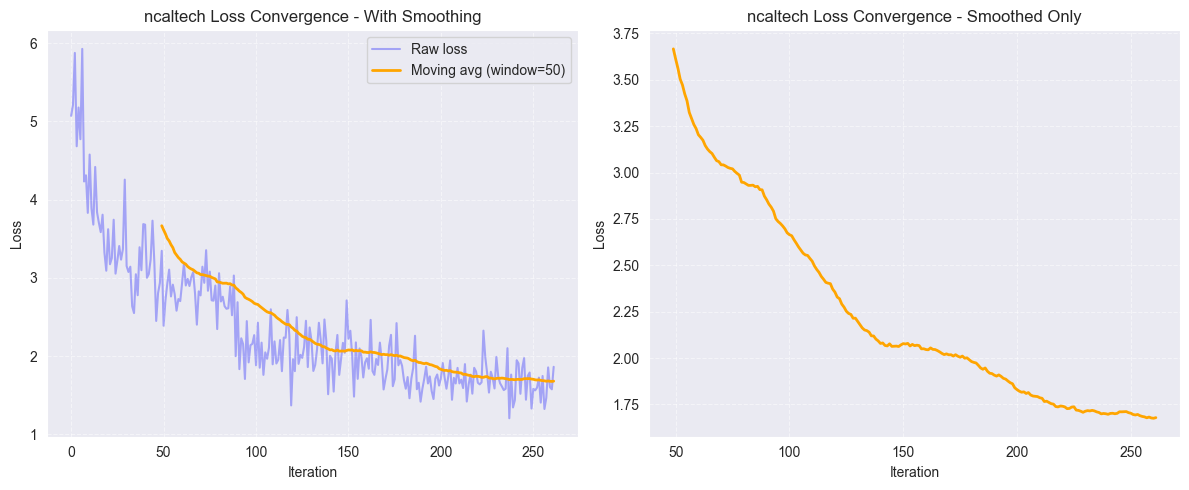


Loss Statistics:
  Initial loss: 5.0720
  Final loss: 1.8621
  Final smoothed loss: 1.6786
  Reduction: 66.9%


In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def plot_loss_convergence(loss_list, window=50, title=None, xlabel="Iteration", ylabel="Loss"):
    """
    Plots the loss over iterations to visualize convergence.

    Parameters:
    - loss_list: List or array of loss values over iterations
    - title: Plot title
    - xlabel: X-axis label
    - ylabel: Y-axis label
    """
    if title is None:
        title = f"{dataset} Loss Convergence"

    plt.figure(figsize=(12,5))

    # Plot raw loss
    plt.subplot(1, 2, 1)
    plt.plot(loss_list, alpha=0.3, color='blue', label='Raw loss')
    moving_mean = np.convolve(loss_list, np.ones(window)/window, mode='valid')
    plt.plot(range(window-1, len(loss_list)), moving_mean, color='orange', linewidth=2, label=f'Moving avg (window={window})')
    plt.title(f"{title} - With Smoothing")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()

    # Plot smoothed loss only
    plt.subplot(1, 2, 2)
    plt.plot(range(window-1, len(loss_list)), moving_mean, color='orange', linewidth=2)
    plt.title(f"{title} - Smoothed Only")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"\nLoss Statistics:")
    print(f"  Initial loss: {loss_list[0]:.4f}")
    print(f"  Final loss: {loss_list[-1]:.4f}")
    print(f"  Final smoothed loss: {moving_mean[-1]:.4f}")
    print(f"  Reduction: {(loss_list[0] - moving_mean[-1]) / loss_list[0] * 100:.1f}%")

plot_loss_convergence(losses)

# Model Evaluation on Test Set

In [10]:
# Process test set if not already done
dataset_obj.process(modes=["test"])
num_test_samples = dataset_obj.get_mode_length("test")
print(f"Number of test samples: {num_test_samples}")

# Create test set BatchManager
test_set = BatchManager(
    dataset=dataset_obj,
    batch_size=8,
    mode="test"
)


📂 Processing folder: gerenuk


gerenuk:   0%|          | 0/6 [00:00<?, ?it/s]


📂 Processing folder: hawksbill


hawksbill:   0%|          | 0/15 [00:00<?, ?it/s]


📂 Processing folder: headphone


headphone:   0%|          | 0/7 [00:00<?, ?it/s]


📂 Processing folder: ant


ant:   0%|          | 0/7 [00:00<?, ?it/s]


📂 Processing folder: butterfly


butterfly:   0%|          | 0/15 [00:00<?, ?it/s]


📂 Processing folder: lamp


lamp:   0%|          | 0/10 [00:00<?, ?it/s]


📂 Processing folder: strawberry


strawberry:   0%|          | 0/6 [00:00<?, ?it/s]


📂 Processing folder: water_lilly


water_lilly:   0%|          | 0/7 [00:00<?, ?it/s]


📂 Processing folder: chandelier


chandelier:   0%|          | 0/17 [00:00<?, ?it/s]


📂 Processing folder: dragonfly


dragonfly:   0%|          | 0/11 [00:00<?, ?it/s]


📂 Processing folder: crab


crab:   0%|          | 0/12 [00:00<?, ?it/s]


📂 Processing folder: pagoda


pagoda:   0%|          | 0/8 [00:00<?, ?it/s]


📂 Processing folder: dollar_bill


dollar_bill:   0%|          | 0/9 [00:00<?, ?it/s]


📂 Processing folder: emu


emu:   0%|          | 0/9 [00:00<?, ?it/s]


📂 Processing folder: inline_skate


inline_skate:   0%|          | 0/6 [00:00<?, ?it/s]


📂 Processing folder: platypus


platypus:   0%|          | 0/6 [00:00<?, ?it/s]


📂 Processing folder: dalmatian


dalmatian:   0%|          | 0/11 [00:00<?, ?it/s]


📂 Processing folder: cup


cup:   0%|          | 0/10 [00:00<?, ?it/s]


📂 Processing folder: airplanes


airplanes:   0%|          | 0/120 [00:00<?, ?it/s]


📂 Processing folder: joshua_tree


joshua_tree:   0%|          | 0/11 [00:00<?, ?it/s]


📂 Processing folder: cougar_body


cougar_body:   0%|          | 0/8 [00:00<?, ?it/s]


📂 Processing folder: grand_piano


grand_piano:   0%|          | 0/16 [00:00<?, ?it/s]


📂 Processing folder: trilobite


trilobite:   0%|          | 0/14 [00:00<?, ?it/s]


📂 Processing folder: brontosaurus


brontosaurus:   0%|          | 0/7 [00:00<?, ?it/s]


📂 Processing folder: wild_cat


wild_cat:   0%|          | 0/6 [00:00<?, ?it/s]


📂 Processing folder: pigeon


pigeon:   0%|          | 0/8 [00:00<?, ?it/s]


📂 Processing folder: dolphin


dolphin:   0%|          | 0/11 [00:00<?, ?it/s]


📂 Processing folder: soccer_ball


soccer_ball:   0%|          | 0/11 [00:00<?, ?it/s]


📂 Processing folder: wrench


wrench:   0%|          | 0/7 [00:00<?, ?it/s]


📂 Processing folder: scorpion


scorpion:   0%|          | 0/14 [00:00<?, ?it/s]


📂 Processing folder: flamingo_head


flamingo_head:   0%|          | 0/8 [00:00<?, ?it/s]


📂 Processing folder: nautilus


nautilus:   0%|          | 0/9 [00:00<?, ?it/s]


📂 Processing folder: accordion


accordion:   0%|          | 0/9 [00:00<?, ?it/s]


📂 Processing folder: cougar_face


cougar_face:   0%|          | 0/11 [00:00<?, ?it/s]


📂 Processing folder: pyramid


pyramid:   0%|          | 0/10 [00:00<?, ?it/s]


📂 Processing folder: camera


camera:   0%|          | 0/8 [00:00<?, ?it/s]


📂 Processing folder: barrel


barrel:   0%|          | 0/8 [00:00<?, ?it/s]


📂 Processing folder: schooner


schooner:   0%|          | 0/10 [00:00<?, ?it/s]


📂 Processing folder: cellphone


cellphone:   0%|          | 0/10 [00:00<?, ?it/s]


📂 Processing folder: panda


panda:   0%|          | 0/7 [00:00<?, ?it/s]


📂 Processing folder: revolver


revolver:   0%|          | 0/13 [00:00<?, ?it/s]


📂 Processing folder: lobster


lobster:   0%|          | 0/7 [00:00<?, ?it/s]


📂 Processing folder: menorah


menorah:   0%|          | 0/14 [00:00<?, ?it/s]


📂 Processing folder: lotus


lotus:   0%|          | 0/11 [00:00<?, ?it/s]


📂 Processing folder: stapler


stapler:   0%|          | 0/8 [00:00<?, ?it/s]


📂 Processing folder: crocodile


crocodile:   0%|          | 0/8 [00:00<?, ?it/s]


📂 Processing folder: chair


chair:   0%|          | 0/10 [00:00<?, ?it/s]


📂 Processing folder: helicopter


helicopter:   0%|          | 0/14 [00:00<?, ?it/s]


📂 Processing folder: minaret


minaret:   0%|          | 0/12 [00:00<?, ?it/s]


📂 Processing folder: starfish


starfish:   0%|          | 0/14 [00:00<?, ?it/s]


📂 Processing folder: ceiling_fan


ceiling_fan:   0%|          | 0/8 [00:00<?, ?it/s]


📂 Processing folder: ketch


ketch:   0%|          | 0/18 [00:00<?, ?it/s]


📂 Processing folder: mayfly


mayfly:   0%|          | 0/6 [00:00<?, ?it/s]


📂 Processing folder: wheelchair


wheelchair:   0%|          | 0/10 [00:00<?, ?it/s]


📂 Processing folder: bass


bass:   0%|          | 0/9 [00:00<?, ?it/s]


📂 Processing folder: yin_yang


yin_yang:   0%|          | 0/9 [00:00<?, ?it/s]


📂 Processing folder: crocodile_head


crocodile_head:   0%|          | 0/9 [00:00<?, ?it/s]


📂 Processing folder: saxophone


saxophone:   0%|          | 0/6 [00:00<?, ?it/s]


📂 Processing folder: beaver


beaver:   0%|          | 0/8 [00:00<?, ?it/s]


📂 Processing folder: mandolin


mandolin:   0%|          | 0/7 [00:00<?, ?it/s]


📂 Processing folder: bonsai


bonsai:   0%|          | 0/20 [00:00<?, ?it/s]


📂 Processing folder: Leopards


Leopards:   0%|          | 0/30 [00:00<?, ?it/s]


📂 Processing folder: car_side


car_side:   0%|          | 0/19 [00:00<?, ?it/s]


📂 Processing folder: ibis


ibis:   0%|          | 0/12 [00:00<?, ?it/s]


📂 Processing folder: electric_guitar


electric_guitar:   0%|          | 0/12 [00:00<?, ?it/s]


📂 Processing folder: kangaroo


kangaroo:   0%|          | 0/14 [00:00<?, ?it/s]


📂 Processing folder: stegosaurus


stegosaurus:   0%|          | 0/10 [00:00<?, ?it/s]


📂 Processing folder: ferry


ferry:   0%|          | 0/11 [00:00<?, ?it/s]


📂 Processing folder: snoopy


snoopy:   0%|          | 0/6 [00:00<?, ?it/s]


📂 Processing folder: umbrella


umbrella:   0%|          | 0/12 [00:00<?, ?it/s]


📂 Processing folder: rhino


rhino:   0%|          | 0/10 [00:00<?, ?it/s]


📂 Processing folder: okapi


okapi:   0%|          | 0/7 [00:00<?, ?it/s]


📂 Processing folder: watch


watch:   0%|          | 0/37 [00:00<?, ?it/s]


📂 Processing folder: brain


brain:   0%|          | 0/16 [00:00<?, ?it/s]


📂 Processing folder: gramophone


gramophone:   0%|          | 0/9 [00:00<?, ?it/s]


📂 Processing folder: scissors


scissors:   0%|          | 0/7 [00:00<?, ?it/s]


📂 Processing folder: rooster


rooster:   0%|          | 0/8 [00:00<?, ?it/s]


📂 Processing folder: cannon


cannon:   0%|          | 0/7 [00:00<?, ?it/s]


📂 Processing folder: binocular


binocular:   0%|          | 0/6 [00:00<?, ?it/s]


📂 Processing folder: anchor


anchor:   0%|          | 0/7 [00:00<?, ?it/s]


📂 Processing folder: octopus


octopus:   0%|          | 0/6 [00:00<?, ?it/s]


📂 Processing folder: buddha


buddha:   0%|          | 0/14 [00:00<?, ?it/s]


📂 Processing folder: laptop


laptop:   0%|          | 0/13 [00:00<?, ?it/s]


📂 Processing folder: windsor_chair


windsor_chair:   0%|          | 0/9 [00:00<?, ?it/s]


📂 Processing folder: hedgehog


hedgehog:   0%|          | 0/9 [00:00<?, ?it/s]


📂 Processing folder: pizza


pizza:   0%|          | 0/9 [00:00<?, ?it/s]


📂 Processing folder: euphonium


euphonium:   0%|          | 0/11 [00:00<?, ?it/s]


📂 Processing folder: stop_sign


stop_sign:   0%|          | 0/11 [00:00<?, ?it/s]


📂 Processing folder: Motorbikes


Motorbikes:   0%|          | 0/121 [00:00<?, ?it/s]


📂 Processing folder: sea_horse


sea_horse:   0%|          | 0/10 [00:00<?, ?it/s]


📂 Processing folder: flamingo


flamingo:   0%|          | 0/11 [00:00<?, ?it/s]


📂 Processing folder: ewer


ewer:   0%|          | 0/14 [00:00<?, ?it/s]


📂 Processing folder: garfield


garfield:   0%|          | 0/6 [00:00<?, ?it/s]


📂 Processing folder: crayfish


crayfish:   0%|          | 0/11 [00:00<?, ?it/s]


📂 Processing folder: Faces_easy


Faces_easy:   0%|          | 0/66 [00:00<?, ?it/s]


📂 Processing folder: sunflower


sunflower:   0%|          | 0/14 [00:00<?, ?it/s]


📂 Processing folder: llama


llama:   0%|          | 0/13 [00:00<?, ?it/s]


📂 Processing folder: elephant


elephant:   0%|          | 0/11 [00:00<?, ?it/s]


📂 Processing folder: tick


tick:   0%|          | 0/8 [00:00<?, ?it/s]


📂 Processing folder: metronome


metronome:   0%|          | 0/6 [00:00<?, ?it/s]

Number of test samples: 1329


In [27]:
# Comprehensive test evaluation
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

evgnn.eval()

all_predictions = []
all_references = []
all_confidences = []

print("Running evaluation on test set...")
num_test_batches = num_test_samples // 32 + (1 if num_test_samples % 32 != 0 else 0)

with torch.no_grad():
    for i in range(num_test_batches):
        examples = next(test_set)
        reference = examples.y.to(device)
        out = evgnn(examples)

        # Get predictions and confidence scores
        probabilities = torch.softmax(out, dim=-1)
        prediction = out.argmax(dim=-1)
        confidence = probabilities.max(dim=-1)[0]

        # Store results
        all_predictions.extend(prediction.cpu().numpy())
        all_references.extend(reference.cpu().numpy())
        all_confidences.extend(confidence.cpu().numpy())

        if (i + 1) % 10 == 0:
            current_acc = np.mean(np.array(all_predictions) == np.array(all_references))
            print(f"Processed {i+1}/{num_test_batches} batches | Current accuracy: {current_acc:.4f}")

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_references = np.array(all_references)
all_confidences = np.array(all_confidences)


Running evaluation on test set...
Processed 10/269 batches | Current accuracy: 0.7250
Processed 20/269 batches | Current accuracy: 0.7438
Processed 30/269 batches | Current accuracy: 0.7458
Processed 40/269 batches | Current accuracy: 0.7438
Processed 50/269 batches | Current accuracy: 0.7300
Processed 60/269 batches | Current accuracy: 0.7417
Processed 70/269 batches | Current accuracy: 0.7500
Processed 80/269 batches | Current accuracy: 0.7500
Processed 90/269 batches | Current accuracy: 0.7542
Processed 100/269 batches | Current accuracy: 0.7450
Processed 110/269 batches | Current accuracy: 0.7341
Processed 120/269 batches | Current accuracy: 0.7385
Processed 130/269 batches | Current accuracy: 0.7423
Processed 140/269 batches | Current accuracy: 0.7393
Processed 150/269 batches | Current accuracy: 0.7417
Processed 160/269 batches | Current accuracy: 0.7422
Processed 170/269 batches | Current accuracy: 0.7485
Processed 180/269 batches | Current accuracy: 0.7500
Processed 190/269 bat

# Test Results and Metrics

In [28]:
# Calculate overall accuracy
accuracy = np.mean(all_predictions == all_references)
print("\n" + "="*80)
print(f"FINAL TEST RESULTS")
print("="*80)
print(f"Total test samples: {len(all_references)}")
print(f"Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Mean Confidence: {np.mean(all_confidences):.4f}")

# Per-class accuracy
print("\n" + "-"*80)
print("Per-Class Performance:")
print("-"*80)
classes = dataset_obj.get_info().classes
for class_idx, class_name in enumerate(classes):
    mask = all_references == class_idx
    if mask.sum() > 0:
        class_acc = np.mean(all_predictions[mask] == all_references[mask])
        class_count = mask.sum()
        class_conf = np.mean(all_confidences[mask])
        print(f"{class_name:15s} | Accuracy: {class_acc:.4f} | Samples: {class_count:4d} | Avg Confidence: {class_conf:.4f}")

# Classification report
print("\n" + "-"*80)
print("Detailed Classification Report:")
print("-"*80)
print(classification_report(all_references, all_predictions, target_names=classes, digits=4))



FINAL TEST RESULTS
Total test samples: 2152
Overall Accuracy: 0.7500 (75.00%)
Mean Confidence: 0.8503

--------------------------------------------------------------------------------
Per-Class Performance:
--------------------------------------------------------------------------------
cars            | Accuracy: 0.7313 | Samples: 1042 | Avg Confidence: 0.8448
background      | Accuracy: 0.7676 | Samples: 1110 | Avg Confidence: 0.8555

--------------------------------------------------------------------------------
Detailed Classification Report:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

        cars     0.7471    0.7313    0.7391      1042
  background     0.7527    0.7676    0.7600      1110

    accuracy                         0.7500      2152
   macro avg     0.7499    0.7494    0.7496      2152
weighted avg     0.7499    0.7500    0.7499      2152



# Confusion Matrix Visualization

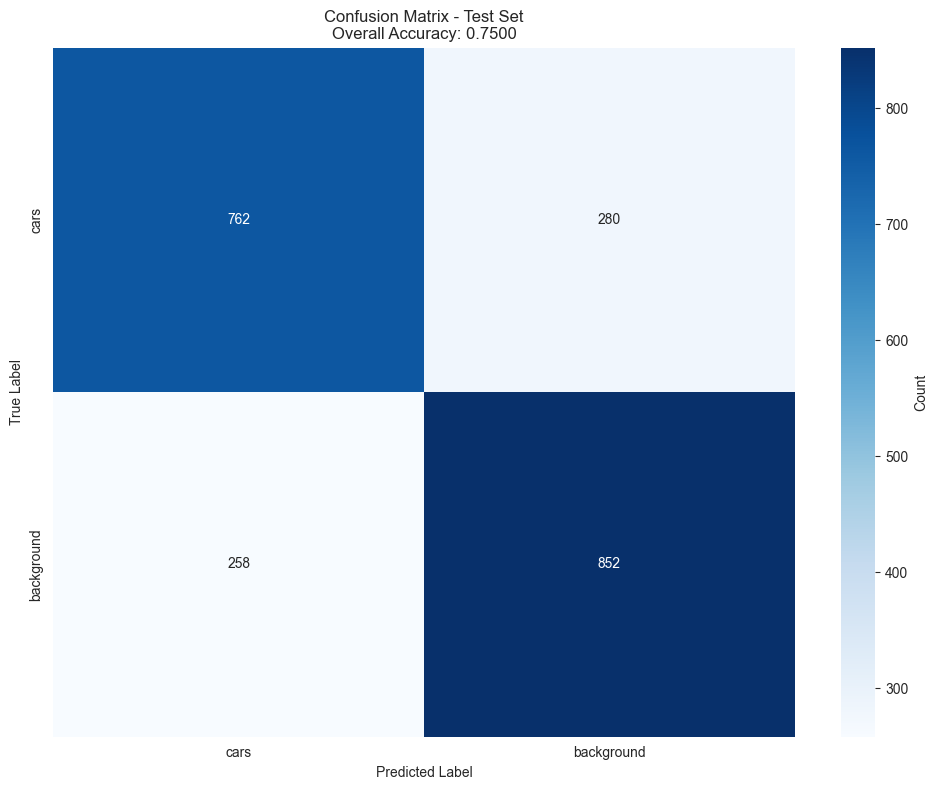

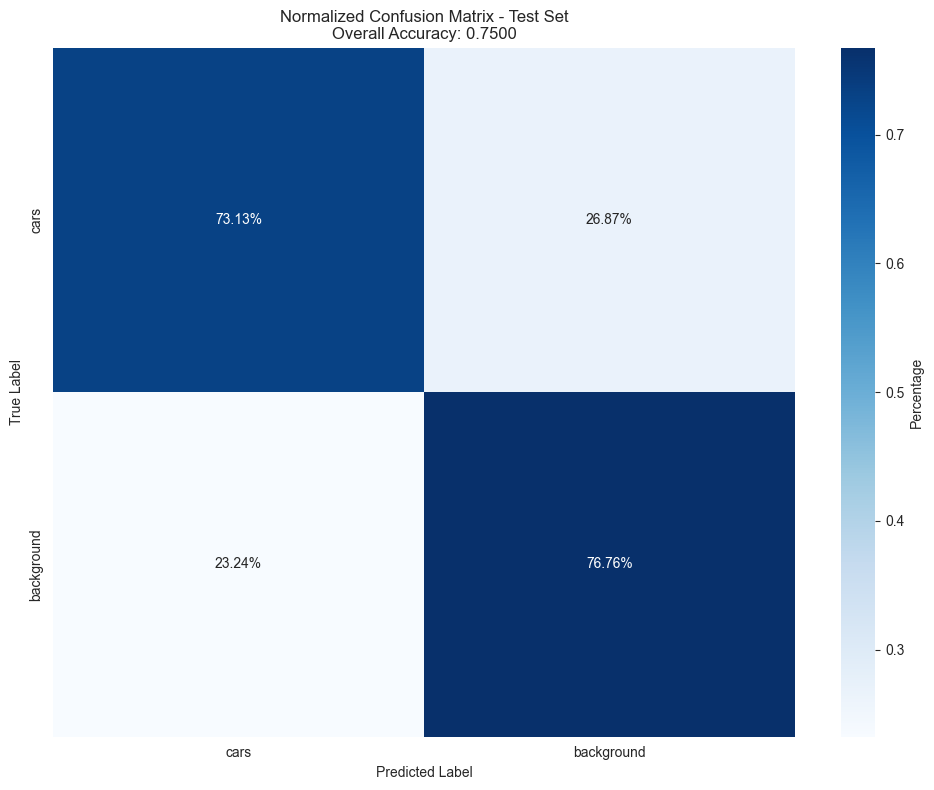

In [29]:
# Compute confusion matrix
cm = confusion_matrix(all_references, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - Test Set\nOverall Accuracy: {accuracy:.4f}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Normalized confusion matrix (percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Percentage'})
plt.title(f'Normalized Confusion Matrix - Test Set\nOverall Accuracy: {accuracy:.4f}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


# Confidence Distribution Analysis

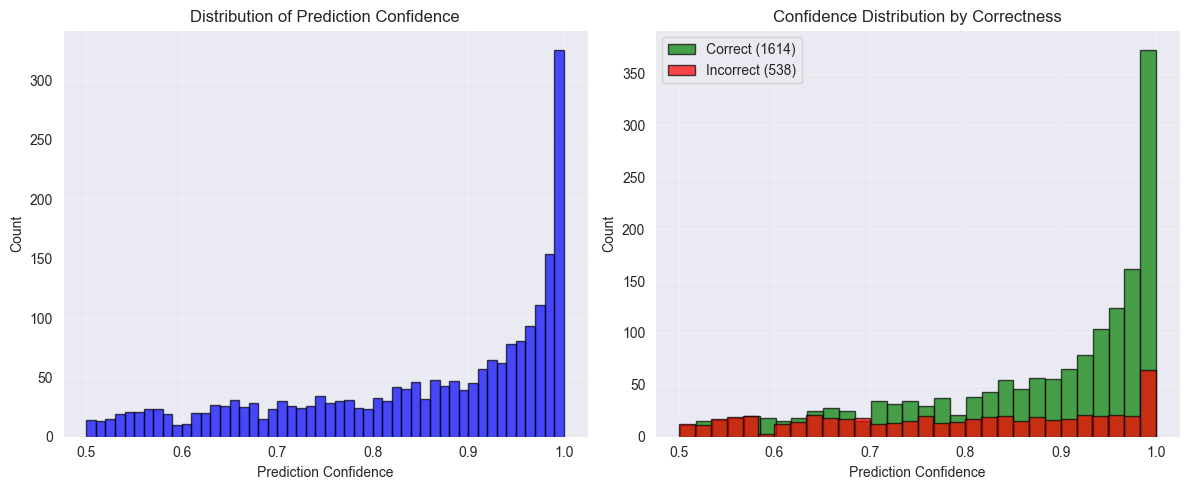


Confidence Statistics:
  Correct predictions - Mean confidence: 0.8719, Median: 0.9225
  Incorrect predictions - Mean confidence: 0.7857, Median: 0.8004


In [30]:
# Plot confidence distribution
plt.figure(figsize=(12, 5))

# Overall confidence distribution
plt.subplot(1, 2, 1)
plt.hist(all_confidences, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Prediction Confidence')
plt.ylabel('Count')
plt.title('Distribution of Prediction Confidence')
plt.grid(True, alpha=0.3)

# Confidence by correctness
plt.subplot(1, 2, 2)
correct_mask = all_predictions == all_references
correct_conf = all_confidences[correct_mask]
incorrect_conf = all_confidences[~correct_mask]

plt.hist(correct_conf, bins=30, alpha=0.7, label=f'Correct ({len(correct_conf)})', color='green', edgecolor='black')
plt.hist(incorrect_conf, bins=30, alpha=0.7, label=f'Incorrect ({len(incorrect_conf)})', color='red', edgecolor='black')
plt.xlabel('Prediction Confidence')
plt.ylabel('Count')
plt.title('Confidence Distribution by Correctness')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nConfidence Statistics:")
print(f"  Correct predictions - Mean confidence: {np.mean(correct_conf):.4f}, Median: {np.median(correct_conf):.4f}")
print(f"  Incorrect predictions - Mean confidence: {np.mean(incorrect_conf):.4f}, Median: {np.median(incorrect_conf):.4f}")


# Save Test Results

In [34]:
# Save detailed results
results = {
    'accuracy': float(accuracy),
    'num_samples': len(all_references),
    'predictions': all_predictions.tolist(),
    'references': all_references.tolist(),
    'confidences': all_confidences.tolist(),
    'per_class_accuracy': {
        class_name: float(np.mean(all_predictions[all_references == idx] == all_references[all_references == idx]))
        for idx, class_name in enumerate(classes)
        if (all_references == idx).sum() > 0
    }
}

import json
import os

# Get the architecture type from the model
conv_type = evgnn.model.conv_type if hasattr(evgnn.model, 'conv_type') else 'fuse'

# Create results directory if it doesn't exist
results_dir = os.path.join(project_root, 'results')
os.makedirs(results_dir, exist_ok=True)

# Save with descriptive filename including dataset and architecture
results_filename = f'test_results_{dataset}_{conv_type}.json'
results_path = os.path.join(results_dir, results_filename)

with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"\n✅ Test results saved to: {results_path}")
print(f"   Architecture: {conv_type}")
print(f"   Accuracy: {accuracy:.4f}")



✅ Test results saved to: /Users/hannes/Documents/GitHub/GNNBenchmark/results/test_results_ncars_ori_aegnn.json
   Architecture: ori_aegnn
   Accuracy: 0.7500
